## 【案例】SVHN街道实景门牌识别

### 导包

In [1]:
#配置相关环境
import os
import torch
os.environ['KMP_DUPLICATE_LIB_OK']='True' #用于避免jupyter环境突然关闭
torch.backends.cudnn.benchmark=True #用于加速GPU运算的代码

In [2]:
#导入pytorch一个完整流程所需的可能全部的包
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import models as m
from torch.utils.data import DataLoader

In [3]:
#导入作为辅助工具的各类包
import matplotlib.pyplot as plt #可视化
from time import time #计算时间、记录时间
import datetime
import random #控制随机性
import numpy as np
import pandas as pd
import gc #garbage collector 垃圾回收

In [4]:
#设置全局的随机数种子，这些随机数种子只能提供有限的控制
#并不能完全令模型稳定下来
torch.manual_seed(1412) #torch
random.seed(1412) #random
np.random.seed(1412) #numpy.random

In [5]:
#GPU系统会返回True，CPU系统会返回False
torch.cuda.is_available()

True

In [6]:
#GPU系统会令device = "gpu", cpu系统会令device = "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

### 数据，数据增强

In [8]:
#导入数据
train = torchvision.datasets.SVHN(root ='I:\F盘 + 代码\F盘\datasets\SVHN'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = T.ToTensor()
                                 )

In [9]:
train[6][0]

tensor([[[0.3255, 0.3294, 0.3294,  ..., 0.5843, 0.5882, 0.5961],
         [0.3373, 0.3333, 0.3294,  ..., 0.5882, 0.5686, 0.5725],
         [0.3451, 0.3373, 0.3255,  ..., 0.5490, 0.5294, 0.5294],
         ...,
         [0.3373, 0.3137, 0.3216,  ..., 0.2235, 0.2588, 0.2667],
         [0.3412, 0.3137, 0.3255,  ..., 0.2510, 0.3020, 0.3059],
         [0.3373, 0.3176, 0.3216,  ..., 0.2667, 0.3294, 0.3255]],

        [[0.2667, 0.2706, 0.2706,  ..., 0.5529, 0.5529, 0.5608],
         [0.2784, 0.2745, 0.2706,  ..., 0.5608, 0.5451, 0.5490],
         [0.2863, 0.2784, 0.2667,  ..., 0.5255, 0.5098, 0.5098],
         ...,
         [0.2784, 0.2549, 0.2588,  ..., 0.2431, 0.2784, 0.2941],
         [0.2824, 0.2510, 0.2627,  ..., 0.2627, 0.3137, 0.3255],
         [0.2784, 0.2549, 0.2588,  ..., 0.2745, 0.3412, 0.3451]],

        [[0.1843, 0.1804, 0.1882,  ..., 0.5098, 0.5176, 0.5255],
         [0.1882, 0.1843, 0.1882,  ..., 0.5216, 0.5137, 0.5176],
         [0.1961, 0.1882, 0.1843,  ..., 0.5059, 0.4980, 0.

In [10]:
test = torchvision.datasets.SVHN(root ='I:\F盘 + 代码\F盘\datasets\SVHN'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = T.ToTensor())

In [11]:
train

Dataset SVHN
    Number of datapoints: 73257
    Root location: I:\F盘 + 代码\F盘\datasets\SVHN
    Split: train
    StandardTransform
Transform: ToTensor()

In [12]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: I:\F盘 + 代码\F盘\datasets\SVHN
    Split: test
    StandardTransform
Transform: ToTensor()

In [13]:
for x,y in train:
    print(x.shape)
    print(y)
    break #打印其中一个样本

torch.Size([3, 32, 32])
1


In [14]:
np.unique(train.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [15]:
#让每个数据集随机显示5张图像
def plotsample(data): #只能够接受tensor格式的图像
    fig, axs = plt.subplots(1,5,figsize=(10,10)) #建立子图
    for i in range(5):
        num = random.randint(0,len(data)-1) #首先选取随机数，随机选取五次
        #抽取数据中对应的图像对象，make_grid函数可将任意格式的图像的通道数升为3，而不改变图像原始的数据
        #而展示图像用的imshow函数最常见的输入格式也是3通道
        npimg = torchvision.utils.make_grid(data[num][0]).numpy()
        nplabel = data[num][1] #提取标签
        #将图像由(3, weight, height)转化为(weight, height, 3)，并放入imshow函数中读取
        axs[i].imshow(np.transpose(npimg, (1, 2, 0))) 
        axs[i].set_title(nplabel) #给每个子图加上标签
        axs[i].axis("off") #消除每个子图的坐标轴

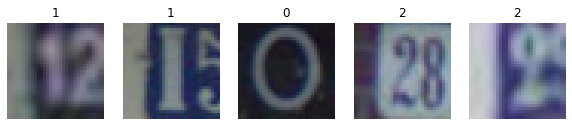

In [16]:
plotsample(train) #分辨率很低，数据集有一定的难度

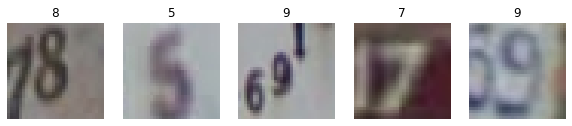

In [17]:
plotsample(test)

In [18]:
#图像太模糊/分辨率太低 - 训练集测试集上都一致
#如果有一些过于清晰的图片，可能反而不好判断
#RandomCrop
#RandomRotation

In [19]:
trainT = T.Compose([T.RandomCrop(28)
                   ,T.RandomRotation(degrees = [-30,30])
                   ,T.ToTensor()
                   ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])])

In [20]:
testT = T.Compose([T.CenterCrop(28)
                  ,T.ToTensor()
                  ,T.Normalize(mean = [0.485,0.456,0.406]
                                ,std = [0.229,0.224,0.225])])

In [21]:
train = torchvision.datasets.SVHN(root ='I:\F盘 + 代码\F盘\datasets\SVHN'
                                 ,split ="train"
                                 ,download = False
                                 ,transform = trainT
                                 )

In [22]:
test = torchvision.datasets.SVHN(root ='I:\F盘 + 代码\F盘\datasets\SVHN'
                                 ,split ="test"
                                 ,download = False
                                 ,transform = testT
                                )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


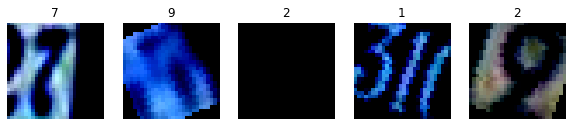

In [23]:
plotsample(train)

### 架构

In [24]:
#小型数据集 - 比较浅、参数量整体较少
#ResNet18，VGG13/16

In [25]:
#基于小型数据集，首先考虑使用各个经典架构中比较浅、但学习能力又比较强的架构
#比如ResNet18、VGG16、Inception也可以考虑
torch.manual_seed(1412)
resnet18_ = m.resnet18()
vgg16_ = m.vgg16() #VGG本来参数量就很大，因此我个人较少使用vgg16_bn

In [26]:
#32x32 - 2个池化/2个步长为2的卷积层
# （2） + （3） - AlexNet

In [27]:
#查看网络架构，从中选择我们希望使用的部分
#时刻要注意原始架构是在ImageNet数据集上构建的，图像的尺寸、输入、输出都发生了变化
#小图像尺寸意味着池化层/步长为2的卷积层出现的次数有限，惯例来说只能出现2次，最终的特征图尺寸需要是7x7
#输出变化意味着最后的层需要自己写
resnet18_

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
class MyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=3
                                              ,stride=1,padding=1,bias=False)
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) #删除池化层
        
        #后续的架构直接从经典架构中选
        #对尺寸很小的数据集而言，我们的深度本来就不深，因此可以试着在特征图数量上有所增加（增加宽度）
        self.block2 = resnet18_.layer2 #2个残差单元
        self.block3 = resnet18_.layer3 #2个残差单元
        #自适应平均池化+线性层，此处都与残差网络一致
        self.avgpool = resnet18_.avgpool
        #输出的线性层自己写，以确保输出的类别数量正确
        self.fc = nn.Linear(in_features=256, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],256)
        x = self.fc(x)
        return x

In [29]:
vgg16_

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
[*vgg16_.features[0:9]] #包含了某些对象的对象/generator

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True)]

In [31]:
class MyVgg(nn.Module):
    def __init__(self):
        super().__init__()
        
        #在9层之后增加一个单独的卷积层，再加入池化层，构成(卷积x2+池化) + (卷积x3+池化)的类似AlexNet的结构
        self.features = nn.Sequential(*vgg16_.features[0:9] #星号用于解码
                                     ,nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
                                     ,nn.ReLU(inplace=True)
                                     ,nn.MaxPool2d(2,2, padding=0, dilation=1, ceil_mode=False))
        #进入线性层时输入通道数发生变化，因此线性层需要重写
        #输出层也需要重写
        self.avgpool = vgg16_.avgpool
        self.fc = nn.Sequential(nn.Linear(7*7*128, out_features=4096,bias=True)
                                ,*vgg16_.classifier[1:6]
                                ,nn.Linear(in_features=4096, out_features=10,bias=True))
    
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],7*7*128)
        x = self.fc(x)
        return x

In [32]:
from torchinfo import summary

In [33]:
summary(MyResNet(),(10,3,28,28),depth=2,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [10, 64, 28, 28]          --
|    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
|    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
|    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
|    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
|    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
|    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
|    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10]                  2,570
Total params: 2,629,706
Trainable params: 2,629,706
Non-

In [34]:
summary(MyVgg(),(10,3,28,28),depth=2,device="cpu")

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [10, 128, 7, 7]           --
|    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,792
|    └─ReLU: 2-2                         [10, 64, 28, 28]          --
|    └─Conv2d: 2-3                       [10, 64, 28, 28]          36,928
|    └─ReLU: 2-4                         [10, 64, 28, 28]          --
|    └─MaxPool2d: 2-5                    [10, 64, 14, 14]          --
|    └─Conv2d: 2-6                       [10, 128, 14, 14]         73,856
|    └─ReLU: 2-7                         [10, 128, 14, 14]         --
|    └─Conv2d: 2-8                       [10, 128, 14, 14]         147,584
|    └─ReLU: 2-9                         [10, 128, 14, 14]         --
|    └─Conv2d: 2-10                      [10, 128, 14, 14]         147,584
|    └─ReLU: 2-11                        [10, 128, 14, 14]         --
|    └─MaxPool2d: 2-12                   [10, 128, 7, 7]        

In [35]:
#残差网络的参数量少很多，但是总计算量是VGG的两倍还多
#同时，VGG模型占用的内存更大，所以VGG需要更大的显存，但在GPU上VGG理论上应该更快

#在这个过程中，我们是从已经实例化的类中直接复制层来使用
#因此我们复用经典架构的部分，参数已经被实例化好了
#因此实例化具体的MyResNet()时没有参数生成
[*MyResNet().block2[0].parameters()][0][0][0] #复制的部分参数是一致的

tensor([[ 0.0324, -0.0175,  0.0459],
        [ 0.0728, -0.0392,  0.0903],
        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward>)

In [36]:
[*resnet18_.layer2[0].conv1.parameters()][0][0][0]

tensor([[ 0.0324, -0.0175,  0.0459],
        [ 0.0728, -0.0392,  0.0903],
        [-0.0266, -0.0177, -0.0227]], grad_fn=<SelectBackward>)

In [37]:
#没有复用经典架构的部分，则在我们实例化网络的时候才有参数
[*resnet18_.fc.parameters()] #自己设立的部分参数是不同的
[*MyResNet().fc.parameters()]

[Parameter containing:
 tensor([[ 0.0218, -0.0385, -0.0548,  ...,  0.0045, -0.0612,  0.0406],
         [-0.0398,  0.0063,  0.0567,  ..., -0.0390,  0.0392, -0.0345],
         [-0.0231, -0.0487, -0.0456,  ..., -0.0538,  0.0066, -0.0088],
         ...,
         [ 0.0070, -0.0560, -0.0430,  ...,  0.0526, -0.0575,  0.0610],
         [-0.0354, -0.0283,  0.0108,  ..., -0.0044, -0.0565,  0.0460],
         [ 0.0033,  0.0593,  0.0278,  ..., -0.0409, -0.0437,  0.0202]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0122, -0.0585,  0.0398, -0.0387,  0.0612, -0.0471,  0.0494,  0.0117,
          0.0264,  0.0493], requires_grad=True)]

### Early Stopping

In [38]:
class EarlyStopping():
    def __init__(self, patience = 5, tol = 0.0005): #惯例地定义我们所需要的一切变量/属性\
        #当连续patience次迭代时，这一轮迭代的损失与历史最低损失之间的差值小于阈值时
        #就触发提前停止
        
        self.patience = patience
        self.tol = tol #tolerance，累积5次都低于tol才会触发停止
        self.counter = 0 #计数，计算现在已经累积了counter次
        self.lowest_loss = None
        self.early_stop = False #True - 提前停止，False - 不要提前停止
    
    def __call__(self,val_loss):
        if self.lowest_loss == None: #这是第一轮迭代
            self.lowest_loss = val_loss
        elif self.lowest_loss - val_loss > self.tol:
            self.lowest_loss = val_loss
            self.counter = 0
        elif self.lowest_loss - val_loss < self.tol:
            self.counter += 1
            print("\t NOTICE: Early stopping counter {} of {}".format(self.counter,self.patience))
            if self.counter >= self.patience:
                print('\t NOTICE: Early Stopping Actived')
                self.early_stop = True
        return self.early_stop
        #这一轮迭代的损失与历史最低损失之间的差 - 阈值

### 训练函数

In [39]:
#3个样本，3个备选类别

#sigma -> (3,3)

In [40]:
sigma = torch.ones([3,3]) + np.random.normal(size=(3,3))

In [41]:
sigma #zhat/sigma值最高的那一列所对应的类别就是这个样本的预测类别

tensor([[ 1.3365,  1.5069,  0.9017],
        [ 0.2944,  2.1113,  0.2333],
        [ 2.0792, -1.1104,  0.3480]], dtype=torch.float64)

In [42]:
yhat = torch.max(sigma,1)[1]

In [43]:
y = torch.tensor([1,1,2])

In [44]:
(yhat == y).sum()/3

tensor(0.6667)

In [45]:
a = ["apple","banana","orange"]

In [46]:
def IterOnce(net,criterion,opt,x,y):
    """
    对模型进行一次迭代的函数
    
    net: 实例化后的架构
    criterion: 损失函数
    opt: 优化算法
    x: 这一个batch中所有的样本
    y: 这一个batch中所有样本的真实标签
    """
    sigma = net.forward(x)
    loss = criterion(sigma,y)
    loss.backward()
    opt.step()
    opt.zero_grad(set_to_none=True) #比起设置梯度为0，让梯度为None会更节约内存
    yhat = torch.max(sigma,1)[1]
    correct = torch.sum(yhat == y)
    return correct,loss

In [47]:
def TestOnce(net,criterion,x,y):
    """
    对一组数据进行测试并输出测试结果的函数
    
    net: 经过训练后的架构
    criterion：损失函数
    x：要测试的数据的所有样本
    y：要测试的数据的真实标签
    """
    #对测试，一定要阻止计算图追踪
    #这样可以节省很多内存，加速运算
    with torch.no_grad(): 
        sigma = net.forward(x)
        loss = criterion(sigma,y)
        yhat = torch.max(sigma,1)[1]
        correct = torch.sum(yhat == y)
    return correct,loss

In [48]:
def fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH):
    """
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率/损失
    以实现对模型的监控
    实现模型的保存
    
    参数说明：
    net: 实例化后的网络
    batchdata：使用Dataloader分割后的训练数据
    testdata：使用Dataloader分割后的测试数据
    criterion：所使用的损失函数
    opt：所使用的优化算法
    epochs：一共要使用完整数据集epochs次
    tol：提前停止时测试集上loss下降的阈值，连续5次loss下降不超过tol就会触发提前停止
    modelname：现在正在运行的模型名称，用于保存权重时作为文件名
    PATH：将权重文件保存在path目录下
    
    """
    
    SamplePerEpoch = batchdata.dataset.__len__() #整个epoch里有多少个样本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None
    
    for epoch in range(1,epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            y = y.view(x.shape[0])
            correct, loss = IterOnce(net,criterion,opt,x,y)
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct
            
            if (batch_idx+1) % 125 == 0:
                #现在进行到了哪个epoch
                #现在训练到了多少个样本
                #总共要训练多少个样本
                #现在的训练的样本占总共需要训练的样本的百分比
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch
                                                       ,trainedsamples
                                                       ,allsamples
                                                       ,100*trainedsamples/allsamples))
            
        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch #平均每个样本上的损失
        trainlosslist.append(TrainLossThisEpoch)
    
        #每次训练完一个epoch，就在测试集上验证一下模型现在的效果
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            y = y.view(x.shape[0])
            correct, loss = TestOnce(net,criterion,x,y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testlosslist.append(TestLossThisEpoch)
        
        #对每一个epoch，打印训练和测试的结果
        #训练集上的损失，测试集上的损失，训练集上的准确率，测试集上的准确率
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch
                                                                                                  ,TestLossThisEpoch
                                                                                                  ,TrainAccThisEpoch
                                                                                                  ,TestAccThisEpoch))
        
        #如果测试集准确率出现新高/测试集loss出现新低，那我会保存现在的这一组权重
        if highestacc == None: #首次进行测试
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(),os.path.join(PATH,modelname+".pt"))
            print("\t Weight Saved")
        
        #提前停止
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == "True":
            break
            
    print("Complete")
    return trainlosslist, testlosslist

In [49]:
#神经网络的训练流程

#1、向前传播
#2、求解损失函数
#3、反向传播 - 求解梯度
#4、基于梯度，对权重进行迭代
#5、梯度清零

In [50]:
#测试过程

#确定没有相关的梯度会生成/阻止计算图的追踪
#1、向前传播
#2、求解损失函数

In [51]:
#net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH

In [52]:
train

Dataset SVHN
    Number of datapoints: 73257
    Root location: I:\F盘 + 代码\F盘\datasets\SVHN
    Split: train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(28, 28), padding=None)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [53]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: I:\F盘 + 代码\F盘\datasets\SVHN
    Split: test
    StandardTransform
Transform: Compose(
               CenterCrop(size=(28, 28))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [54]:
bs = 128
#net
lr = 0.001
alpha = 0.99
gamma = 0
wd = 0

In [55]:
batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False,num_workers = 4) #线程 - 调度计算资源的最小单位
testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False,num_workers = 4)

In [56]:
#损失函数和优化算法

criterion = nn.CrossEntropyLoss(reduction="sum") #进行损失函数计算时，最后输出结果的计算模式
opt = optim.RMSprop(net.parameters(),lr=lr,alpha=alpha,momentum=gamma,weight_decay=wd)

NameError: name 'net' is not defined

In [ ]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,tol=10**(-5)):
    
    torch.manual_seed(1412)
    
    #分割数据
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False,num_workers = 4) #线程 - 调度计算资源的最小单位
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False,num_workers = 4)
    
    #损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum") #进行损失函数计算时，最后输出结果的计算模式
    opt = optim.RMSprop(net.parameters(),lr=lr
                        ,alpha=alpha,momentum=gamma,weight_decay=wd)
    
    #训练与测试
    trainloss, testloss = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)
    
    return trainloss, testloss

In [57]:
#实例化
#trainloss, testloss = full_procedure(XXXX)
#plotloss()

In [58]:
#绘图函数
def plotloss(trainloss, testloss):
    plt.figure(figsize=(10, 7))
    plt.plot(trainloss, color="red", label="Trainloss")
    plt.plot(testloss, color="orange", label="Testloss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

### GPU版本的训练函数

In [59]:
torch.cuda.manual_seed(1412)
torch.cuda.manual_seed_all(1412)

In [60]:
torch.cuda.is_available()

True

In [61]:
device

device(type='cuda')

In [75]:
def fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH):
    """
    对模型进行训练，并在每个epoch后输出训练集和测试集上的准确率/损失
    以实现对模型的监控
    实现模型的保存
    
    参数说明：
    net: 实例化后的网络
    batchdata：使用Dataloader分割后的训练数据
    testdata：使用Dataloader分割后的测试数据
    criterion：所使用的损失函数
    opt：所使用的优化算法
    epochs：一共要使用完整数据集epochs次
    tol：提前停止时测试集上loss下降的阈值，连续5次loss下降不超过tol就会触发提前停止
    modelname：现在正在运行的模型名称，用于保存权重时作为文件名
    PATH：将权重文件保存在path目录下
    
    """
    
    SamplePerEpoch = batchdata.dataset.__len__() #整个epoch里有多少个样本
    allsamples = SamplePerEpoch*epochs
    trainedsamples = 0
    trainlosslist = []
    testlosslist = []
    early_stopping = EarlyStopping(tol=tol)
    highestacc = None
    
    for epoch in range(1,epochs+1):
        net.train()
        correct_train = 0
        loss_train = 0
        for batch_idx, (x, y) in enumerate(batchdata):
            #non_blocking 非阻塞 = True
            x = x.to(device,non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
            correct, loss = IterOnce(net,criterion,opt,x,y)
            
            #计算样本总量、总的correct、loss
            trainedsamples += x.shape[0]
            loss_train += loss
            correct_train += correct
            
            if (batch_idx+1) % 125 == 0:
                #现在进行到了哪个epoch
                #现在训练到了多少个样本
                #总共要训练多少个样本
                #现在的训练的样本占总共需要训练的样本的百分比
                print('Epoch{}:[{}/{}({:.0f}%)]'.format(epoch
                                                       ,trainedsamples
                                                       ,allsamples
                                                       ,100*trainedsamples/allsamples))
            
        TrainAccThisEpoch = float(correct_train*100)/SamplePerEpoch
        TrainLossThisEpoch = float(loss_train*100)/SamplePerEpoch #平均每个样本上的损失
        trainlosslist.append(TrainLossThisEpoch)
        
        #清理GPU内存
        #清理掉一个epoch循环下面不再需要的中间变量
        del x,y,correct,loss,correct_train,loss_train #删除数据与变量
        gc.collect() #清除数据与变量相关的缓存
        torch.cuda.empty_cache() #缓存分配器分配出去的内存给释放掉
    
        #每次训练完一个epoch，就在测试集上验证一下模型现在的效果
        net.eval()
        loss_test = 0
        correct_test = 0
        loss_test = 0
        TestSample = testdata.dataset.__len__()

        for x,y in testdata:
            x = x.to(device, non_blocking=True)
            y = y.to(device,non_blocking=True).view(x.shape[0])
            correct, loss = TestOnce(net,criterion,x,y)
            loss_test += loss
            correct_test += correct

        TestAccThisEpoch = float(correct_test * 100)/TestSample
        TestLossThisEpoch = float(loss_test * 100)/TestSample
        testlosslist.append(TestLossThisEpoch)
        
        #清理GPU内存
        del x,y,correct,loss,correct_test,loss_test
        gc.collect()
        torch.cuda.empty_cache()
        
        #对每一个epoch，打印训练和测试的结果
        #训练集上的损失，测试集上的损失，训练集上的准确率，测试集上的准确率
        print("\t Train Loss:{:.6f}, Test Loss:{:.6f}, Train Acc:{:.3f}%, Test Acc:{:.3f}%".format(TrainLossThisEpoch
                                                                                                  ,TestLossThisEpoch
                                                                                                  ,TrainAccThisEpoch
                                                                                                  ,TestAccThisEpoch))
        
        #如果测试集准确率出现新高/测试集loss出现新低，那我会保存现在的这一组权重
        if highestacc == None: #首次进行测试
            highestacc = TestAccThisEpoch
        if highestacc < TestAccThisEpoch:
            highestacc = TestAccThisEpoch
            torch.save(net.state_dict(),os.path.join(PATH,modelname+".pt"))
            print("\t Weight Saved")
        
        #提前停止
        early_stop = early_stopping(TestLossThisEpoch)
        if early_stop == "True":
            break
            
    print("Complete")
    return trainlosslist, testlosslist

In [71]:
#GPU内存优化管理机制 - 缓存内存分配器

#数据x - 80，分配给它100字节的资源，20字节空闲
#80 - 张量内存
#20 - 缓存分配器指定的更多的缓存

#GPU - 使用了100字节的资源

#del 张量内存
#torch.cuda.empty_cache() 缓存分配器指定的那些缓存

#GPU显存进行监控的时候

In [72]:
torch.cuda.memory_allocated() #张量内存的占用情况（现状）
torch.cuda.memory_reserved() #缓存分配器占用的所有内存（现状）
torch.cuda.max_memory_allocated() #自GPU运行以来占用过的最大张量内存（峰值）

1891122176

In [73]:
def full_procedure(net,epochs,bs,modelname, PATH, lr=0.001,alpha=0.99,gamma=0,wd=0,tol=10**(-5)):
    
    torch.cuda.manual_seed(1412)
    torch.cuda.manual_seed_all(1412)
    torch.manual_seed(1412)
    
    #分割数据
    batchdata = DataLoader(train,batch_size=bs,shuffle=True
                       ,drop_last=False,pin_memory=True)
    testdata = DataLoader(test,batch_size=bs,shuffle=False
                      ,drop_last=False,pin_memory=True)
    
    #损失函数，优化算法
    criterion = nn.CrossEntropyLoss(reduction="sum") #进行损失函数计算时，最后输出结果的计算模式
    opt = optim.RMSprop(net.parameters(),lr=lr
                        ,alpha=alpha,momentum=gamma,weight_decay=wd)
    
    #训练与测试
    trainloss, testloss = fit_test(net,batchdata,testdata,criterion,opt,epochs,tol,modelname,PATH)
    
    return trainloss, testloss

In [66]:
#pin_memory 控制是否将生成的数据放置在锁页内存当中

#内存 - 程序运行的空间 - 8G，16G，24G
#硬盘（虚拟内存） - 储存文件的空间 - 2T，5T，1G，1T

#“锁页内存” - 只能在内存中存放，不允许与硬盘进行交换的程序/数据

#pin_memory = True - 保证你的内存资源比较充足

### 模型选择

In [72]:
MyResNet()

MyResNet(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

In [73]:
MyVgg()

MyVgg(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4):

In [ ]:
#效果、运算速度（效率）、潜力

In [ ]:
#效果 - 模型的泛化能力（偏差、方差） 准确率要高、模型要稳定 - 我们需要对同一个架构进行多次训练来衡量方差
#运算速度 - 看模型运行的时间
#潜力 - 起点（前几个epochs上能够达到的效果），过拟合（通过调参来抑制过拟合）

In [ ]:
#在每一个架构上，分别运行3个epochs，运行5次

In [ ]:
#回顾模型

In [74]:
from torchinfo import summary
for name,i in[("ResNet",MyResNet()),("VGG",MyVgg())]:
    print("\n")
    print(name)
    print(summary(i,input_size=(10,3,28,28),depth=2,device="cpu"))
    print("\n")



ResNet
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [10, 64, 28, 28]          --
|    └─Conv2d: 2-1                       [10, 64, 28, 28]          1,728
|    └─BatchNorm2d: 2-2                  [10, 64, 28, 28]          128
|    └─ReLU: 2-3                         [10, 64, 28, 28]          --
├─Sequential: 1-2                        [10, 128, 14, 14]         --
|    └─BasicBlock: 2-4                   [10, 128, 14, 14]         230,144
|    └─BasicBlock: 2-5                   [10, 128, 14, 14]         295,424
├─Sequential: 1-3                        [10, 256, 7, 7]           --
|    └─BasicBlock: 2-6                   [10, 256, 7, 7]           919,040
|    └─BasicBlock: 2-7                   [10, 256, 7, 7]           1,180,672
├─AdaptiveAvgPool2d: 1-4                 [10, 256, 1, 1]           --
├─Linear: 1-5                            [10, 10]                  2,570
Total params: 2,629,706
Trainable params: 2,629

In [ ]:
'''
===========TIME WARNING==========
===========运行时间警告===========

CPU：Intel i5-10600 @4.10Ghz
GPU：RTX 2060S GPU

MyResNet
 1 epoch on CPU: 3mins~3mins10s
 1 epoch on GPU: 22s~23s

MyVGG
 1 epoch on CPU: 5min50s~6mins
 1 epoch on GPU：20s~22s
===========运行时间警告============
===========TIME WARNING===========
'''

In [ ]:
#模型训练需要的3个步骤

#for i in range(5):
    #实例化
    #full_procedure()

In [ ]:
#建立目录用于存储模型选择结果
PATH = r"D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ModelSelection"

#使用函数full_procedure中的默认参数，在模型选择时加入时间计算
#基于现有显存，batch_size被设置为256，对于CPU而言最好从64开始设置
#MyResNet
avgtime = [] #用来存放每次循环之后获得的训练时间
for i in range(5): #进行5次训练
    #设置随机数种子
    torch.manual_seed(1412)
    
    #实例化
    resnet18_ = m.resnet18()
    net = MyResNet().to(device,non_blocking=True)
    
    #训练
    start = time() #计算训练时间
    trainloss, testloss = full_procedure(net,epochs=3, bs=256 
                                         ,modelname="model_seletion_resnet"
                                         ,PATH = PATH)
    avgtime.append(time()-start)

In [ ]:
#打印出我们的平均时间
print(np.mean(avgtime))

In [ ]:
#MyVGG
avgtime = []
for i in range(5):
    torch.manual_seed(1412)
    vgg16_ = m.vgg16_bn()
    net = MyVgg().to(device,non_blocking=True)
    start = time() #计算训练时间
    #此时使用的是full_procedure的默认参数
    trainloss, testloss = full_procedure(net,epochs=3, bs=256
                                         ,modelname="model_seletion_vgg"
                                         ,PATH = PATH)
    avgtime.append(time()-start)

In [ ]:
del net
gc.collect()
torch.cuda.empty_cache()
print(np.mean(avgtime))

### 模型调优

#### 更多迭代次数

In [ ]:
'''
===========TIME WARNING==========
===========运行时间警告===========

CPU：Intel i5-10600 @4.10Ghz
GPU：RTX 2060S GPU

MyResNet
 1 epoch on CPU: 3mins~3mins10s
 1 epoch on GPU: 22s~23s
===========运行时间警告============
===========TIME WARNING===========
'''

#尝试增加到10个epochs
PATH = r"D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ConfirmedResNet"
modelname = "myResNet_test0"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet().to(device,non_blocking=True)
start = time() #计算训练时间
trainloss, testloss = full_procedure(net,epochs=10, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH)
print(time()-start)
plotloss(trainloss,testloss)

In [ ]:
#调小提前停止阈值，再进行三次训练，每次30个epochs

PATH = r"D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ConfirmedResNet"

for modelname in ["MyResNet_test1","MyResNet_test2","MyResNet_test3"]:
    print(modelname)
    torch.manual_seed(1412)
    resnet18_ = m.resnet18()
    net = MyResNet().to(device,non_blocking=True)
    start = time() #计算训练时间
    trainloss, testloss = full_procedure(net,epochs=30, bs=256
                                         ,modelname=modelname
                                         ,PATH = PATH
                                         ,tol = 10**(-10))
    print(time()-start)
    plotloss(trainloss,testloss)

#### 让迭代更稳定

In [ ]:
#首先加载之前保存的权重
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet()
net.load_state_dict(torch.load("D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ConfirmedResNet\myResNet_test2.pt"))

In [ ]:
#修改modelname，准备好保存结果
modelname = "MyResNet_stable5"

#控制变量：每次只调整一个参数
#先调整可能对整个学习过程影响最大的参数：学习率
print(modelname)
torch.manual_seed(1412)
start = time() #计算训练时间
#降低学习率，原本的lr=0.001，现在我尝试了0.0075,0.0005，0.00025和0.0002和0.0001五种
trainloss, testloss = full_procedure(net,epochs=30, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,lr = 0.0001 
                                     ,gamma=0
                                     ,tol = 10**(-10))
print(time()-start)
plotloss(trainloss,testloss)

In [ ]:
#在lr稳定的基础上调节gamma
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net.load_state_dict(torch.load("D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ConfirmedResNet\MyResNet_stable5.pt"))

modelname = "MyResNet_stable6"

print(modelname)
start = time() #计算训练时间
net = net.to(device,non_blocking=True)
#基于lr非常小的考虑，同样尝试了非常小的值
trainloss, testloss = full_procedure(net,epochs=30, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,lr = 0.0001
                                     ,gamma = 0.0001
                                     ,tol = 10**(-10)
                                    )
print(time()-start)
plotloss(trainloss,testloss)

#### 对抗过拟合

In [ ]:
modelname = "MyResNet_overfit"

torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet()
net.load_state_dict(torch.load("D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ConfirmedResNet\MyResNet_stable6.pt"))

#在stable6的基础上继续训练
print(modelname)
torch.manual_seed(1412)
net = net.to(device,non_blocking=True)
start = time() #计算训练时间
trainloss, testloss = full_procedure(net,epochs=30, bs=128 #令batch_size下降一半
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,lr = 0.0001
                                     ,gamma= 0.0001
                                     ,tol = 10**(-10)
                                     ,wd = 0.00005) #wd非常敏感，因此要小心地进行调整
print(time()-start)
plotloss(trainloss,testloss)

### 基于新参数进行训练

In [ ]:
#先按大lr进行初期迭代，再按小lr进行后期迭代
PATH = r"D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ConfirmedResNet"
modelname = "myResNet_test0_1"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net = MyResNet().to(device,non_blocking=True) #完全重启，不借用任何过去训练好的参数
start = time() #计算训练时间
trainloss, testloss = full_procedure(net,epochs=15, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,lr=0.001
                                     ,tol = 10**(-10)
                                    )
print(time()-start)
plotloss(trainloss,testloss)

In [ ]:
modelname = "MyResNet_retrain"

torch.manual_seed(1412)
resnet18_ = m.resnet18()
net.load_state_dict(torch.load("D:\Pythonwork\DEEP LEARNING\WEEK 9\models\ConfirmedResNet\myResNet_test0_1.pt"))

print(modelname)
torch.manual_seed(1412)
net = net.to(device,non_blocking=True)
start = time() #计算训练时间
trainloss, testloss = full_procedure(net,epochs=30, bs=128 #令batch_size下降一半
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,lr = 0.00001
                                     ,gamma= 0.0001
                                     ,tol = 10**(-10)
                                     ,wd = 0.00005) #wd非常敏感，因此要小心地进行调整
print(time()-start)
plotloss(trainloss,testloss)

### 架构升级，其他可探索的方向

#### 重新定义架构

In [ ]:
class MyResNet2(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.block1 = nn.Sequential(nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
                                   ,resnet18_.bn1
                                   ,resnet18_.relu) 

        self.block2 = resnet18_.layer2
        self.block3 = resnet18_.layer3
        self.block4 = resnet18_.layer4 #其他地方都不变，但增加原始残差网络中的layer4
        self.avgpool = resnet18_.avgpool
        self.fc = nn.Linear(in_features=512, out_features=10, bias=True)
    
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0],512) #512个输出
        x = self.fc(x)
        return x
    
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net2 = MyResNet2()

summary(net2,(10,3,28,28),depth=2,device="cpu")

#### 在新架构上按大lr先迭代，再按小lr迭代

In [ ]:
'''
===========TIME WARNING==========
===========运行时间警告===========

CPU：Intel i5-10600 @4.10Ghz
GPU：RTX 2060S GPU

MyResNet
 1 epoch on CPU: 9min50s~10mins
 1 epoch on GPU: 18s~20s
===========运行时间警告============
===========TIME WARNING===========
'''

#没有数据增强，回归原始参数

modelname = "MyResNet2_test1"

print(modelname)
torch.manual_seed(1412)
resnet18_ = m.resnet18()
net2 = MyResNet2().to(device,non_blocking=True)
start = time() #计算训练时间
trainloss, testloss = full_procedure(net2,epochs=30, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,tol = 10**(-10))
print(time()-start)
plotloss(trainloss,testloss)

In [ ]:
modelname = "MyResNet2_test2"

start = time() #计算训练时间
trainloss, testloss = full_procedure(net2,epochs=30, bs=256
                                     ,modelname=modelname
                                     ,PATH = PATH
                                     ,tol = 10**(-10)
                                     ,lr = 0.0001)
print(time()-start)
plotloss(trainloss,testloss)